# About this notebook

This notebooks investigates how well a pre-trained `word2vec` model from FastText can capture genre similarities when treating individual genres as words or sentences. The model is tested as is, with no fine-tuning on music related documents.

Each genre, for example `Rock`, is treated as a word and its embedding obtained by the pre-trained model.

Genre similarities are then just the cosine distance between their respective word embeddings.

To investigate how well these embedding similarities reflect musical properties, genre similarities as reported by [`everynoise`](https://everynoise.com) are used for comparison.

This website clusters genres based on musical attributes and thus provides a good baseline.

The methodology of this analysis is as follows:

- Select N most frequently occurring genres based on songs featured on Spotify's curated playlists
- For each pair of these N genres, calculate the cosine distance of `word2vec` embeddings and euclidean distance of `everynoise` embeddings. The latter is effectively based on the `(x, y)` position of the genres in the 2D embedding space.
- For each genre, rank all other genres in terms of decreasing similarity, with the most similar genre assigned the 1st rank and the least similar genre the 100th rank. This creates a ranking for each of the two methods, `word2vec` and `everynoise`.
- Compare the absolute difference in ranking between the two methods. A higher difference suggests that the two methods disagree on a given genre similarity. For example, if `Rock` is the 2nd most similar genre to `Hard Rock` according to `everynoise` but the 50th according to `word2vec`, the two methods for measuring genre similarity lead to different results.
- Assuming that `everynoise` is a faithful representation of genre similarity, we can judge how well `word2vec` performs for the same task by comparing the ranking difference.

As the heatmap in this notebook shows, the rankings of the two methods are frequently quite different, suggesting that `word2vec` is a poor representation of genre similarities.

This is further backed by a one-dimensional ranking of genres and a radial plot.

# Prepare the environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import json
import numpy as np
import fasttext
from sklearn.metrics.pairwise import euclidean_distances as euclidean
from sklearn.metrics.pairwise import cosine_distances as cosine
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pylab as plt
import plotly.express as px
import scipy.stats as stats
import sys
sys.path.append("../")

In [3]:
from src.project_config import DATA_DIR, MODEL_DIR
from src.spotify.utils import get_frequent_genres

In [4]:
CURATED_DIR = os.path.join(DATA_DIR, "Curated_Playlists")

# Load data

In [5]:
# Pre-trained FastText model
ft = fasttext.load_model(os.path.join(MODEL_DIR, 'cc.en.300.bin'))

# Number of genres to include
N = 50

# List of genres by descending order of occurrence
# A) Occurrence based on a user's library
# freq_genres = get_frequent_genres(thr=N)
# B) Occurrence based on Spotify's curated playlists
#    Focus on the top N genres
freq_genres = pd.read_csv(os.path.join(CURATED_DIR, "curated_playlists_genres.csv")).genre.head(N)

# Everynoise genre embedding
df = pd.read_csv(os.path.join(DATA_DIR, "genre_space_everynoise.csv"))

# Only analyse frequently occurring genres
df = df.loc[lambda x: x.genre.isin(freq_genres)].copy()
# Sort these genres by their everynoise embedding
# Because those close according to their (x,y) position are musically similar
# This helps keeping similar genres close together in the heatmap at the end of the notebook
df.sort_values(by=["x", "y"], inplace=True)

In [6]:
df.genre.nunique(), df.shape

(50, (50, 3))

In [7]:
# Prepare everynoise embedding, i.e. (x,y) position as array
df["everynoise_embedding"] = df.apply(lambda row: np.array([row.x, row.y]), axis=1)
# Get word2vec embedding by treating genre as a sentence 
# because some genres are a composite of several words, like "background music"
df["word2vec_embedding"] = df.genre.apply(ft.get_sentence_vector)
df.drop(columns=["x", "y"], inplace=True)

In [8]:
df.head()

genre everynoise_embedding  \
485                rain          [66, 15588]   
1599              sleep         [101, 16442]   
3285   background music         [141, 17707]   
820               metal          [239, 8096]   
5679  alternative metal          [332, 5982]   

                                     word2vec_embedding  
485   [-0.002465, 0.08747462, 0.06555412, 0.06582663...  
1599  [-0.022968562, 0.044469975, 0.05194762, 0.0671...  
3285  [0.0749328, 0.08131899, 0.051911768, 0.0557405...  
820   [0.0052165664, 0.037232004, -0.0670524, 0.0934...  
5679  [-0.036017735, 0.012306588, -0.023121277, 0.07...

In [9]:
# Transform embeddings into a numpy matrix
matrix_everynoise = np.stack(df.everynoise_embedding.values)
matrix_word2vec = np.stack(df.word2vec_embedding.values)

# Calculate genre similarities

In [10]:
# Everynoise embedding similarity based on Euclidean distance
df_everynoise = pd.DataFrame(
    euclidean(matrix_everynoise),
    index=df.genre.values,
    columns=df.genre.values
)

# Word2vec embedding similarity based on Cosine distance
df_word2vec = pd.DataFrame(
    cosine(matrix_word2vec),
    index=df.genre.values,
    columns=df.genre.values
)

In [11]:
df_everynoise.iloc[:5, :5]

rain         sleep  background music        metal  \
rain                  0.000000    854.716912       2120.326862  7493.997131   
sleep               854.716912      0.000000       1265.632253  8347.140828   
background music   2120.326862   1265.632253          0.000000  9611.499623   
metal              7493.997131   8347.140828       9611.499623     0.000000   
alternative metal  9609.682201  10462.550406      11726.555590  2116.044659   

                   alternative metal  
rain                     9609.682201  
sleep                   10462.550406  
background music        11726.555590  
metal                    2116.044659  
alternative metal           0.000000

In [12]:
df_word2vec.iloc[:5, :5]

rain     sleep  background music     metal  \
rain               0.000000  0.799401          0.804673  0.797956   
sleep              0.799401  0.000000          0.840059  0.952170   
background music   0.804673  0.840059          0.000000  0.680932   
metal              0.797956  0.952170          0.680932  0.000000   
alternative metal  0.882510  0.924235          0.647090  0.224927   

                   alternative metal  
rain                        0.882510  
sleep                       0.924235  
background music            0.647090  
metal                       0.224927  
alternative metal           0.000000

In [13]:
# Transform distance matrix into a ranking matrix:
# Given a genre, the closest genre to it will be given rank equal to 1
# and the genre most different a rank equal to N

df_everynoise_ranked = pd.DataFrame(
    np.apply_along_axis(stats.rankdata, arr=df_everynoise.values, axis=1),
    index=df_everynoise.index,
    columns=df_everynoise.columns
).astype(int)

df_word2vec_ranked = pd.DataFrame(
    np.apply_along_axis(stats.rankdata, arr=df_word2vec.values, axis=1),
    index=df_word2vec.index,
    columns=df_word2vec.columns
).astype(int)

In [14]:
df_everynoise_ranked.iloc[:5, :5]

rain  sleep  background music  metal  alternative metal
rain                  1      2                 9     29                 34
sleep                 3      1                 4     29                 34
background music      6      3                 1     29                 34
metal                45     46                48      1                 14
alternative metal    45     46                48     17                  1

In [15]:
df_word2vec_ranked.iloc[:5, :5]

rain  sleep  background music  metal  alternative metal
rain                  1     14                15     12                 33
sleep                 9      1                17     47                 43
background music     46     47                 1     34                 29
metal                42     49                28      1                  2
alternative metal    47     49                30      3                  1

Note that entries in the diagonals are equal to 1 because distance between the two genres is 0.

The lower the ranking, the more similar the two genres are.

The highest ranking is equal to 100 because we have only inlcuded 100 genres in this analysis.

Looking at the second table (`word2vec`) we see that white noise is not similar to the genre metalcore at all (rank 88).

There are other 87 genres that are more similar to white noise than metalcore is.

In fact, background music is the most similar genre (rank 2).

# Visualise word2vec vs everynoise genre similarities

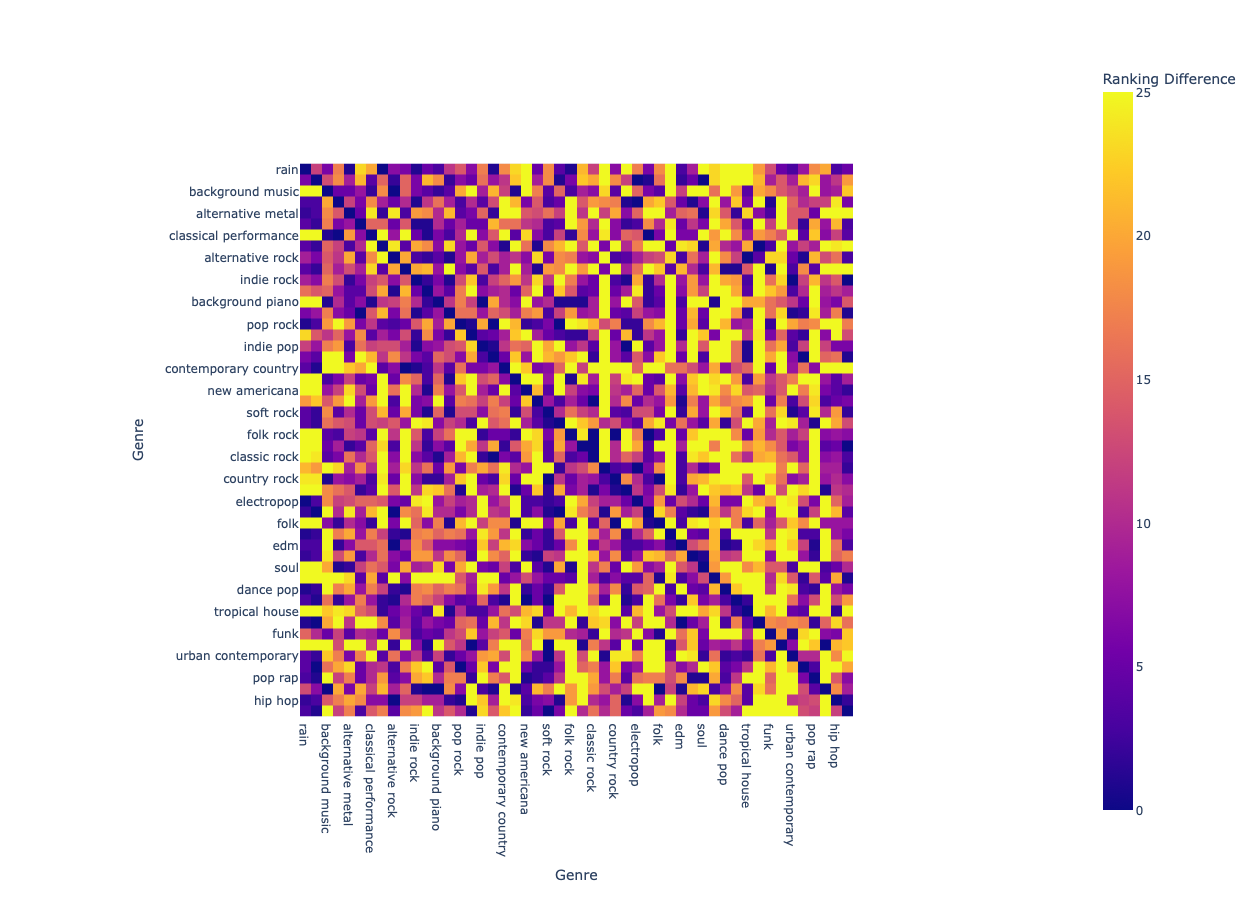

In [16]:
# https://plotly.com/python/annotated-heatmap/
fig = px.imshow(
    (df_word2vec_ranked - df_everynoise_ranked).abs(),
    labels=dict(x="Genre", y="Genre", color="Ranking Difference"),
    width=900,
    height=900,
    zmax=N // 2  # Saturate graph above this value because two methods really disagree on genre similaritya
)
fig.update_traces(
    customdata=np.moveaxis([df_word2vec_ranked, df_everynoise_ranked.astype(int)], 0, -1), 
    hovertemplate="""
    <b>Genre pair:</b> %{x} – %{y}<br>
    <b>Ranking Difference:</b> %{z}<br>
    <b>Ranking Word2Vec vs Everynoise:</b> %{customdata[0]} vs %{customdata[1]}<br>
    """
)
fig.show()

Looking at the heatmap we see that `word2vec` and `everynoise` do not agree very much on many genre pairs as many cells are coloured in yellow.

**Conclusion**: `word2vec` leads to genre similarities that are quite different to those obtained from `everynoise`, which one can treat as capturing genre similarities rather well. Therefore, using a pre-trained `word2vec` model without fine-tuning is not a very good approach to measuring genre similarities.

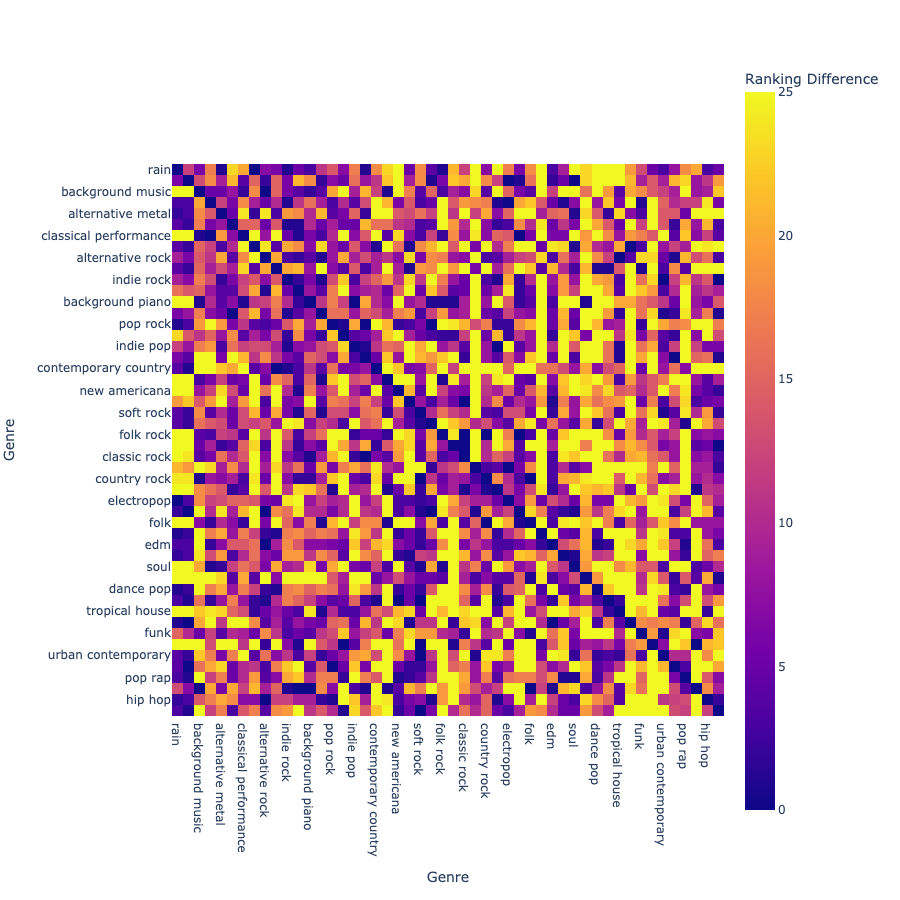

In [17]:
# For Github: visualise a static version of the above Plotly figure
from IPython.display import Image
img_bytes = fig.to_image(format="png")
Image(img_bytes)

## t-SNE

In [18]:
tsne = TSNE(n_components=1, learning_rate="auto", init="random")

In [19]:
df["everynoise_tsne"] = tsne.fit_transform(np.stack(df.everynoise_embedding.values))
df["word2vec_tsne"] = tsne.fit_transform(np.stack(df.word2vec_embedding.values))

In [20]:
def plot_genre_line(ds, col, ax, x_loc=0):
    df = ds.sort_values(by=col).reset_index(drop=True)
    ax.set_yticks(np.arange(0, df.index.max()+1, 1.0))
    labels = [item.get_text() for item in ax.get_yticklabels()]
    labels = [df.genre.iloc[i] for i in range(len(labels))]
    ax.scatter(
        np.zeros(len(df)) + x_loc, 
        np.arange(0, df.index.max()+1, 1.0),
        c=df[col], cmap="gist_rainbow", s=600, marker="s"
    )
    ax.get_xaxis().set_visible(False)
    [ax.spines[m].set_color('white') for m in ["left", "top", "right"]]
    ax.set_yticklabels(labels, rotation=0)
    ax.set_title(col.replace("_", " ").title())

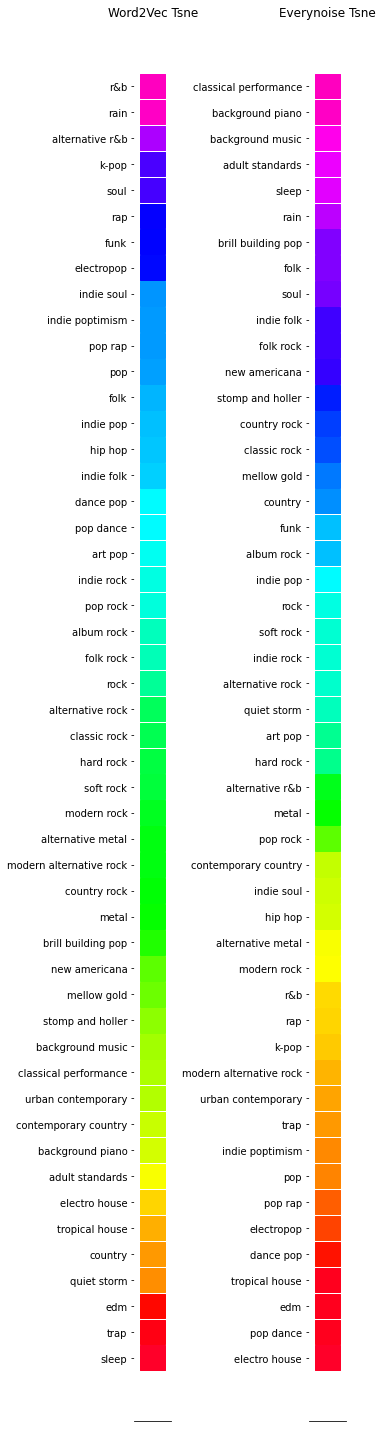

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(5, 20))
fig.canvas.draw()
plot_genre_line(df, "word2vec_tsne", ax[0])
plot_genre_line(df, "everynoise_tsne", ax[1])
plt.tight_layout()

TODO: Add interpretation

## Similarity differences for a specific genre

In [22]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [23]:
chosen_genre = "tropical house"

In [24]:
subset_everynoise = df_everynoise.loc[chosen_genre, df_everynoise.columns.difference([chosen_genre])]
subset_word2vec = df_word2vec.loc[chosen_genre, df_word2vec.columns.difference([chosen_genre])]

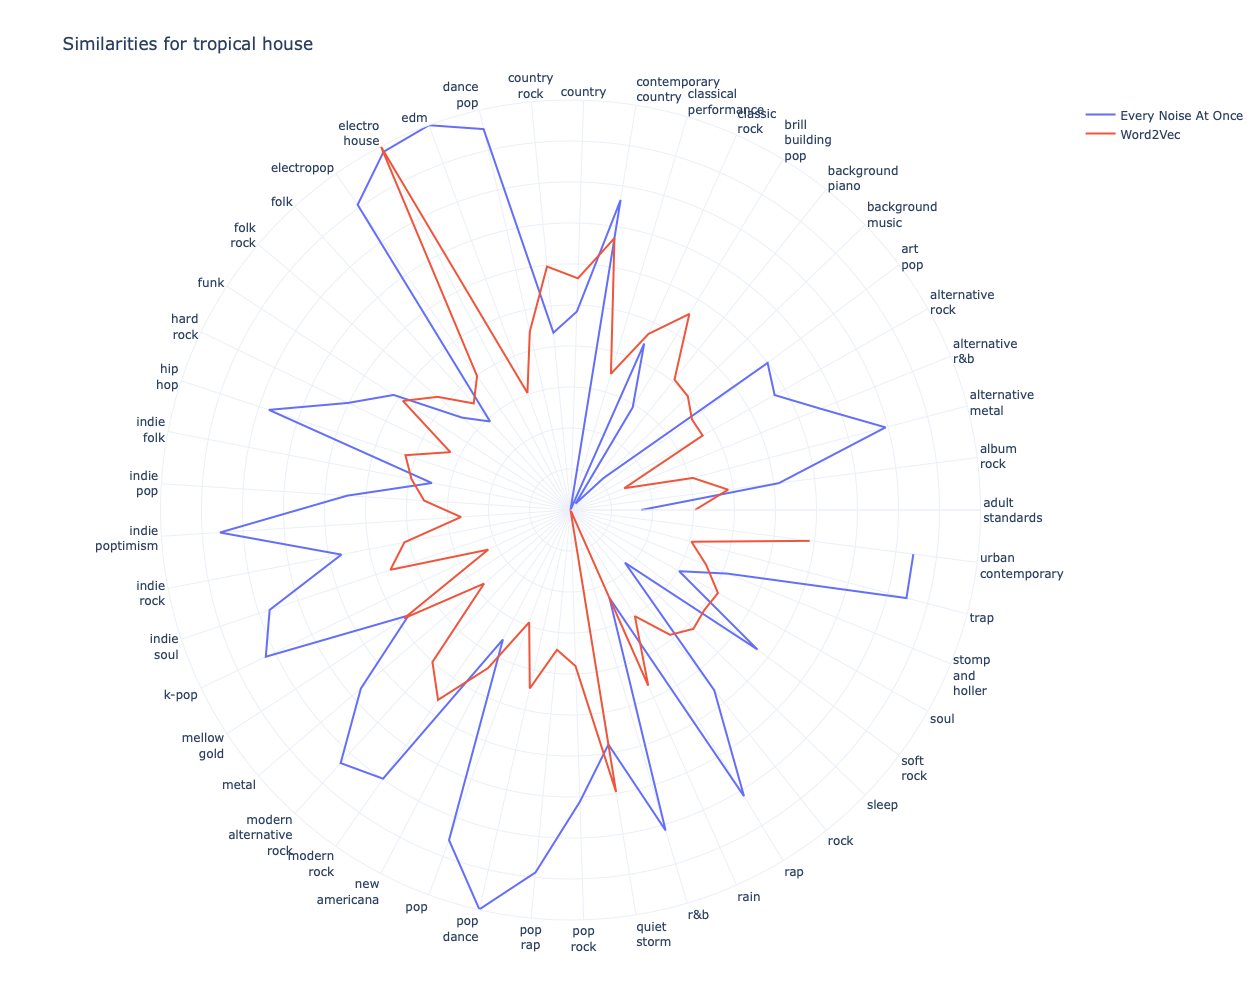

In [25]:
fig = make_subplots(
    rows=1, cols=1,
    specs=[[
        {'type': 'polar'}
    ]],
    column_widths=[1]
)
fig.add_trace(
    go.Scatterpolar(
        r=1 - MinMaxScaler().fit_transform(subset_everynoise.values.reshape(-1, 1)).flatten(),
        theta=subset_everynoise.index.map(lambda x: x.replace(" ", "<br>")),
        name="Every Noise At Once"
    ), 
    row=1, col=1
)
fig.add_trace(
    go.Scatterpolar(
        r=1 - MinMaxScaler().fit_transform(subset_word2vec.values.reshape(-1, 1)).flatten(),
        theta=subset_word2vec.index.map(lambda x: x.replace(" ", "<br>")),
        name="Word2Vec"
    ), 
    row=1, col=1
)
fig.update_layout(
    template="plotly_white",
    title=f"Similarities for {chosen_genre}",
    plot_bgcolor='rgb(255,255,255)',
    polar=dict(
        radialaxis=dict(showticklabels=False, ticks=''),
    ),
    height=1000,
    width=1200
)

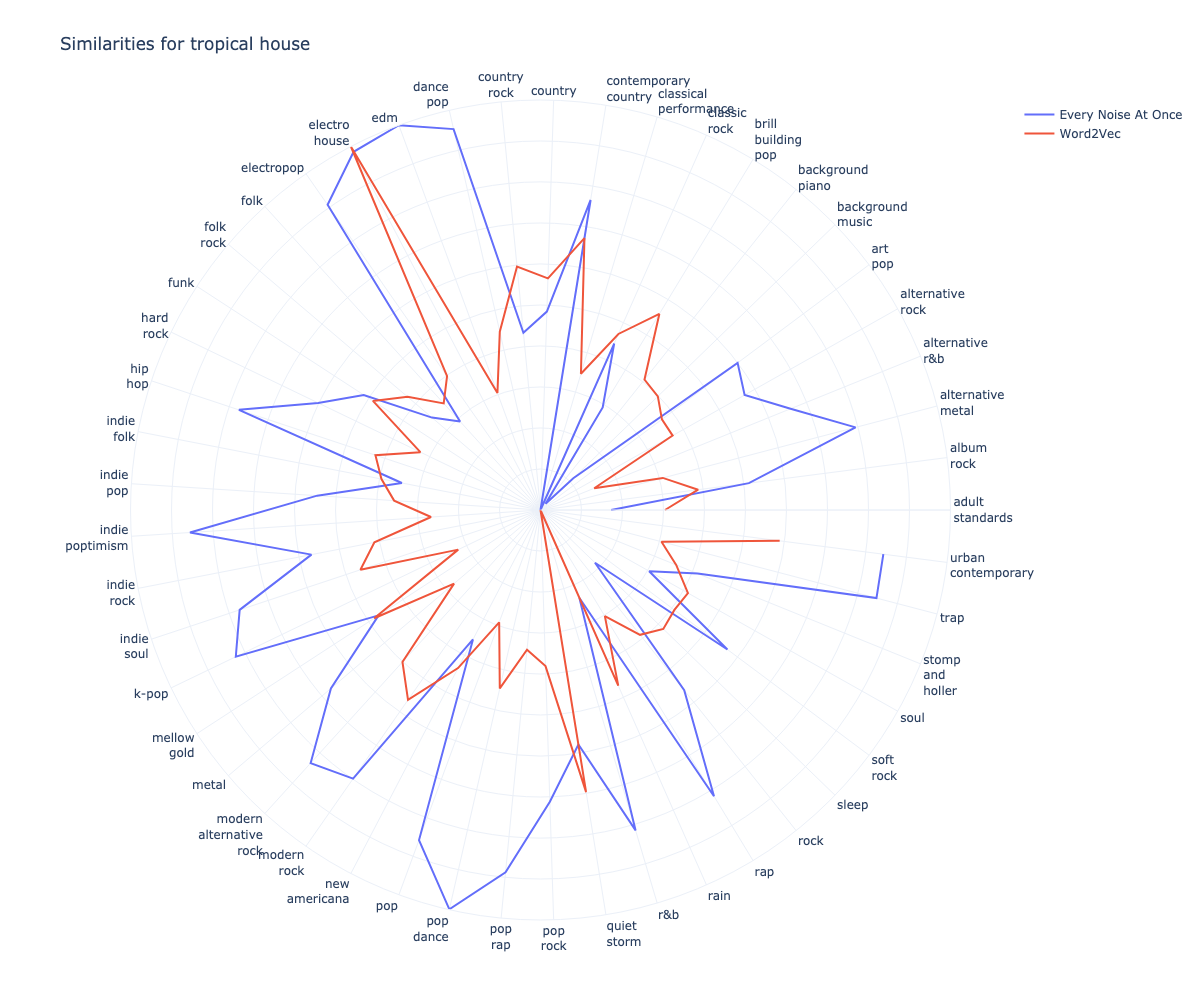

In [26]:
# For Github: visualise a static version of the above Plotly figure
from IPython.display import Image
img_bytes = fig.to_image(format="png")
Image(img_bytes)

TODO: Add interpretation